In [1]:
# A Template NEMS Script suitable for beginners
# Please see docs/architecture.svg for a visual diagram of this code

import logging
import pickle
from pathlib import Path
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nems0.analysis.api
import nems0.initializers
import nems0.preprocessing as preproc
import nems0.uri
from nems0 import db
from nems0 import xforms
from nems0 import recording
from nems0.fitters.api import scipy_minimize
from nems0.signal import RasterizedSignal
from nems import Model

log = logging.getLogger(__name__)

# CONFIGURATION

# figure out data and results paths:
signals_dir = Path(nems0.NEMS_PATH) / 'recordings'
modelspecs_dir = Path(nems0.NEMS_PATH) / 'modelspecs'


In [2]:
def plot_binaural_model(model, X_val, Y_val=None):
    
    # Predict the response to the stimulus spectrogram using the fitted model.
    prediction = model.predict(X_val)
    if Y_val is None:
        cc=0
    else:
        cc = np.corrcoef(prediction[:, 0], Y_val[:, 0])[0, 1]

    wc = model.layers[0].coefficients
    fir = model.layers[1].coefficients

    if len(wc.shape)>2:
        strf=wc[:,:,0] @ fir[:,:,0].T
        if wc.shape[2]>1:
            strf2=wc[:,:,1] @ fir[:,:,1].T
        else:
            strf2=strf
    elif len(fir.shape)>2:
        strf=wc @ fir[:,:,0].T
        if fir.shape[2]>1:
            strf2=wc @ fir[:,:,1].T
        else:
            strf2 = strf
    else:
        strf=wc @ fir.T
        strf2 = strf
    strf *= model.layers[2].coefficients[0]
    strf2 *= model.layers[2].coefficients[1]
    cmax=np.max([np.abs(strf).max(), np.abs(strf2).max()])

    fig=plt.figure()
    spec = fig.add_gridspec(3, 4)

    ax0 = fig.add_subplot(spec[0, :])
    ax1 = fig.add_subplot(spec[1, :])
    ax20 = fig.add_subplot(spec[2, 0])
    ax21 = fig.add_subplot(spec[2, 1])
    ax22 = fig.add_subplot(spec[2, 2:])
    
    bins=550
    b0=bins
    b1=b0+bins
    fs=100
    dur=bins/fs
    chans = X_val.shape[1]
    t=np.linspace(0,dur,bins)
    _x = np.reshape(np.transpose(X_val[b0:b1,:,:],[0,2,1]),(bins,-1)).T
    ax0.imshow(_x, aspect='auto', extent=[0,dur,-0.5,chans+0.5])
    ax0.set_title(f"cc={cc:.3f}")
    if Y_val is not None:
        ax1.plot(t,Y_val[b0:b1,0])
    ax1.plot(t,prediction[b0:b1,0])
    ax1.set_xlim(ax0.get_xlim())
    ax20.imshow(strf, origin='lower', extent=[0,strf.shape[1],-0.5,chans+0.5], clim=[-cmax, cmax])
    ax21.imshow(strf2, origin='lower', extent=[0,strf.shape[1],-0.5,chans+0.5], clim=[-cmax, cmax])

    xin = model.evaluate(input=X_val, n=len(model)-2)['_last_output']
    xrange = np.linspace(xin.min(),xin.max(),100)[:,np.newaxis]
    xout = model.layers[-1].evaluate(xrange)
    if Y_val is not None:
        ax22.plot(xin[:,0],Y_val[:,0],'.', markersize=2, color='lightgray')
    ax22.plot(xrange[:,0],xout[:,0], color='k')


In [3]:
def plot_binaural_layers(model, X_val, Y_val=None):
    x1 = model.evaluate(input=X_val, n=0)['_last_output']
    x2 = model.evaluate(input=X_val, n=1)['_last_output']
    x3 = model.evaluate(input=X_val, n=2)['_last_output']
    x4 = model.evaluate(input=X_val, n=3)['output']

    f,ax = plt.subplots(6,1, sharex=True)

    ax[0].imshow(X_val[:1000,:,0].T, aspect='auto', interpolation='none')
    ax[0].set_ylabel('stim 0')

    ax[1].imshow(X_val[:1000,:,1].T, aspect='auto', interpolation='none')
    ax[1].set_ylabel('stim 1')

    ax[2].plot(x1[:1000,:,0])
    ax[2].plot(x1[:1000,:,1], '--')
    ax[2].set_ylabel('wc1 output')

    ax[3].plot(x2[:1000,0])
    ax[3].plot(x2[:1000,1], '--')
    ax[3].set_ylabel('fir output')

    ax[4].plot(x3[:1000,:])
    ax[4].set_ylabel('wc1 output')

    ax[5].plot(x4[:1000,:])
    if Y_val is not None:
        ax[5].plot(Y_val[:1000,0])
    ax[5].set_ylabel('dexp output')


In [4]:
# testing binaural NAT with various model architectures.
batch=338
modelname="gtgram.fs100.ch18.mono-ld.pop-norm.l1-sev_wc.Nx60-fir.1x20x60-wc.60xR-lvl.R-dexp.R_tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4"
recording_uri = '/auto/data/nems_db/recordings/338/CLT041c_c6cec16ea49389fffff3880d5742bfc3a3cf4924.tgz'

# binaural model
#recording_uri = '/auto/data/nems_db/recordings/338/CLT039c_03fad55eb0b91a734d800a85ad3a78ae790c7d36.tgz'
rec = recording.load_recording(recording_uri)

cellid="CLT041c-054-2"
cellids = ['CLT041c-054-1', 'CLT041c-054-2']
cellids = ['CLT041c-054-2']
cellids = [rec['resp'].chans[6]]
cellids = [rec['resp'].chans[19]]
print("cellids: ", cellids)

ctx = {'rec': rec}
ctx.update(xforms.normalize_sig(sig='resp', norm_method='minmax', **ctx))
ctx.update(xforms.normalize_sig(sig='stim', norm_method='minmax', **ctx))
ctx.update(xforms.split_by_occurrence_counts(epoch_regex='^STIM', **ctx))
ctx.update(xforms.average_away_stim_occurrences(epoch_regex='^STIM', **ctx))
X_est = ctx['est']['stim'].as_continuous().T.copy()
Y_est = ctx['est']['resp'].extract_channels(cellids).as_continuous().T
X_val = ctx['val']['stim'].as_continuous().T.copy()
Y_val = ctx['val']['resp'].extract_channels(cellids).as_continuous().T

X_norm = X_est.max()
X_est /= X_norm
X_val /= X_norm

if True:
    X_est=np.swapaxes(np.reshape(X_est, [-1, 2, 18]), 2, 1)
    X_val=np.swapaxes(np.reshape(X_val, [-1, 2, 18]), 2, 1)

    # shorten est data for speed
    X_est = X_est[:50000, :, :]
    Y_est = Y_est[:50000, :]

    modelspec = 'wcb.18x3x1-fir.15x3x1-wc.2x1-dexp.1'
    modelspec = 'wcb.18x2x2-fir.15x2x2-wc.2x1-relu.1.o.s'
    modelspec = 'wcb.18x2x2-fir.15x2x2-wc.2x1-dexp.1'
else:
    modelspec = 'wc.36x2-fir.15x2-dexp.1'

    # shorten est data for speed
    X_est = X_est[:50000, :]
    Y_est = Y_est[:50000, :]


cellids:  ['CLT041c-051-1']


[nems0.xforms INFO] xforms.normalize_sig(minmax): resp b=0.0, g=3.8620689655172415, dlog(..., -None)
[nems0.xforms INFO] xforms.normalize_sig(minmax): stim b=0.0, g=20.75445560091246, dlog(..., -None)


Initialize model, plot initialized model

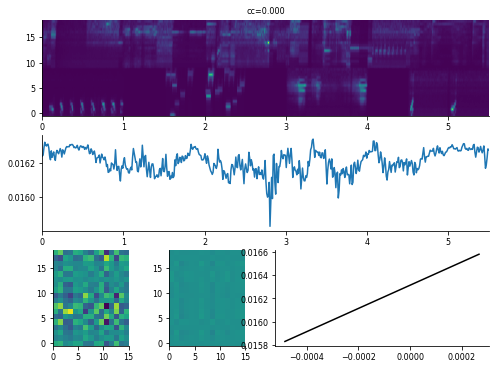

In [5]:
modelspec = 'wcb.18x2x2-fir.15x2x2-wc.2x1-dexp.1'
modelspec = 'wcb.18x2x2-fir.15x2x2-wc.2x1-relu.1.o.s'
model = Model.from_keywords(modelspec)

# Set initial values
# quick & dirty, but may not work as desired
model.sample_from_priors()

plot_binaural_model(model, X_val, Y_val=None)

Fit with TF backend

In [6]:
fitter_options = {'cost_function': 'nmse', 'early_stopping_delay': 100, 'early_stopping_patience': 10,
              'early_stopping_tolerance': 1e-3, 'validation_split': 0.0,
              'learning_rate': 5e-3, 'epochs': 2000}

# Trying a TF fit:
model.layers[-1].skip_nonlinearity()
model = model.fit(input=np.expand_dims(X_est, axis=0),
          target=np.expand_dims(Y_est, axis=0), backend='tf',
          fitter_options=fitter_options,
          batch_size=None)

model.layers[-1].unskip_nonlinearity()
model = model.fit(input=np.expand_dims(X_est, axis=0),
          target=np.expand_dims(Y_est, axis=0), backend='tf',
          fitter_options=fitter_options,
          batch_size=None)

2022-08-27 13:44:30.162675: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-27 13:44:30.795769: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6778 MB memory:  -> device: 0, name: GeForce GTX 1080, pci bus id: 0000:65:00.0, compute capability: 6.1


1 Physical GPUs, 1 Logical GPUs
TF model built...
Model: "UnnamedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 50000, 18, 2)]    0         
                                                                 
 wcb (WeightChannelsMultiTF)  (None, 50000, 2, 2)      72        
                                                                 
 fir (FiniteImpulseResponseT  (None, 50000, 2)         60        
 F)                                                              
                                                                 
 wc (WeightChannelsTF)       (None, 50000, 1)          2         
                                                                 
 relu (StaticNonlinearityTF)  (None, 50000, 1)         3         
                                                                 
Total params: 137
Trainable params: 135
Non-trainable params: 2
______

2022-08-27 13:44:31.689551: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 7605
2022-08-27 13:44:31.692086: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-27 13:44:31.693543: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.2.89, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


Epoch 1/2000
1/1 [==============================] - 0s 475ms/step - loss: 0.8530
Epoch 2/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.8480
Epoch 3/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8441
Epoch 4/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8413
Epoch 5/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8396
Epoch 6/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8388
Epoch 7/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8387
Epoch 8/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8390
Epoch 9/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8393
Epoch 10/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8394
Epoch 11/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8391
Epoch 12/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8383
Epoch 13/2000
1/1 [==================

1/1 [==============================] - 0s 16ms/step - loss: 0.8086
Epoch 103/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8086
Epoch 104/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8085
Epoch 105/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8085
Epoch 106/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8085
Epoch 107/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8085
Epoch 108/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8085
Epoch 109/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8085
Epoch 110/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8085
Epoch 111/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8085
Epoch 112/2000
1/1 [==============================] - 0s 16ms/step - loss: 0.8085
Epoch 00112: early stopping
TF model built...
Model: "UnnamedModel"
_____________________________________________

1/1 [==============================] - 0s 11ms/step - loss: 0.8085
Epoch 75/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8085
Epoch 76/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8085
Epoch 77/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8085
Epoch 78/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8085
Epoch 79/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8085
Epoch 80/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8085
Epoch 81/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8085
Epoch 82/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8085
Epoch 83/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8085
Epoch 84/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8085
Epoch 85/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8085
Epoch 86/2000
1/1 [=======================

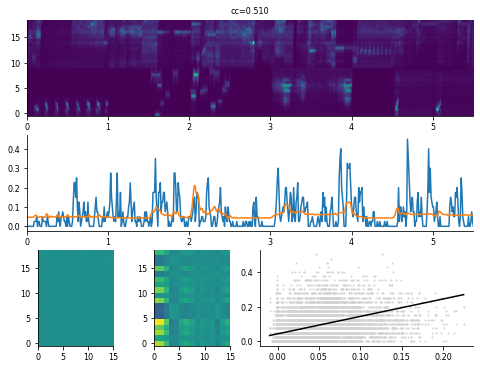

In [7]:
plot_binaural_model(model, X_val, Y_val=Y_val)

Now reinitialize and fit again

In [8]:
model = Model.from_keywords(modelspec)
model.sample_from_priors();
model.sample_from_priors();

In [9]:
fitter_options = {'cost_function': 'nmse', 'early_stopping_delay': 100, 'early_stopping_patience': 10,
              'early_stopping_tolerance': 1e-3, 'validation_split': 0.0,
              'learning_rate': 5e-3, 'epochs': 2000}

# Trying a TF fit:
model.layers[-1].skip_nonlinearity()
model = model.fit(input=np.expand_dims(X_est, axis=0),
          target=np.expand_dims(Y_est, axis=0), backend='tf',
          fitter_options=fitter_options,
          batch_size=None)

model.layers[-1].unskip_nonlinearity()
model = model.fit(input=np.expand_dims(X_est, axis=0),
          target=np.expand_dims(Y_est, axis=0), backend='tf',
          fitter_options=fitter_options,
          batch_size=None)

TF model built...
Model: "UnnamedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 50000, 18, 2)]    0         
                                                                 
 wcb (WeightChannelsMultiTF)  (None, 50000, 2, 2)      72        
                                                                 
 fir (FiniteImpulseResponseT  (None, 50000, 2)         60        
 F)                                                              
                                                                 
 wc (WeightChannelsTF)       (None, 50000, 1)          2         
                                                                 
 relu (StaticNonlinearityTF)  (None, 50000, 1)         3         
                                                                 
Total params: 137
Trainable params: 135
Non-trainable params: 2
______________________________________

1/1 [==============================] - 0s 12ms/step - loss: 0.8101
Epoch 88/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8100
Epoch 89/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8100
Epoch 90/2000
1/1 [==============================] - 0s 17ms/step - loss: 0.8099
Epoch 91/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8099
Epoch 92/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8098
Epoch 93/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8098
Epoch 94/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8098
Epoch 95/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8097
Epoch 96/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8097
Epoch 97/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8097
Epoch 98/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8096
Epoch 99/2000
1/1 [=======================

1/1 [==============================] - 0s 12ms/step - loss: 0.8093
Epoch 60/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8093
Epoch 61/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8093
Epoch 62/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8093
Epoch 63/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8093
Epoch 64/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8093
Epoch 65/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8093
Epoch 66/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8093
Epoch 67/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8093
Epoch 68/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8093
Epoch 69/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8093
Epoch 70/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.8093
Epoch 71/2000
1/1 [=======================

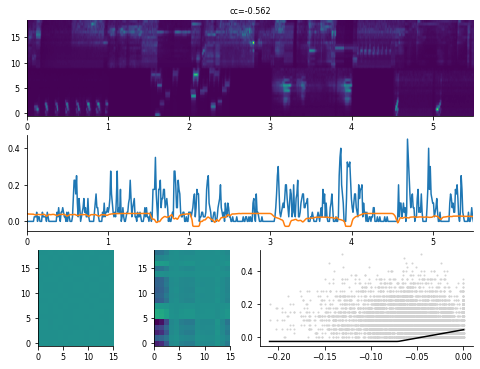

In [10]:
plot_binaural_model(model, X_val, Y_val=Y_val)

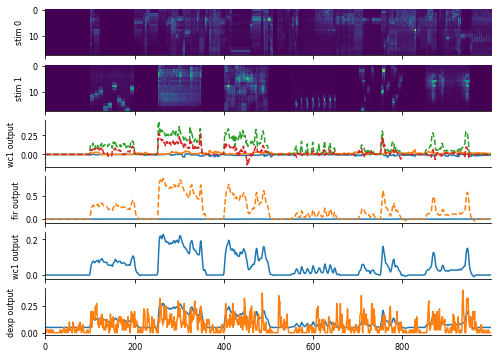

In [26]:
plot_binaural_layers(model, X_val, Y_val=Y_val)

Fit with scipy backend

In [ ]:
print('Fitting without NL ...')
model.layers[-1].skip_nonlinearity()
model = model.fit(input=X_est, target=Y_est, backend='scipy',
          fitter_options={'cost_function': 'nmse', 'options': {'ftol': 0.00000001, 'maxiter': 50}})

print('Now fitting with NL ...')
model.layers[-1].unskip_nonlinearity()
model = model.fit(input=X_est, target=Y_est, backend='scipy',
          fitter_options={'cost_function': 'nmse', 'options': {'ftol': 0.000000001, 'maxiter': 100}})

Test that model does what it's supposed to do with each coefficient

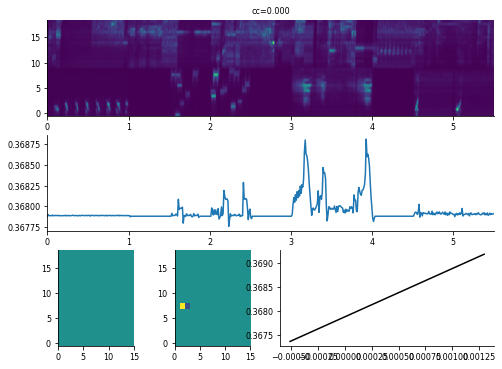

In [5]:
model = Model.from_keywords(modelspec)

wc = model.layers[0]['coefficients'].values
wc[:]=0
wc[7,1,1]=1
model.layers[0]['coefficients'] = wc

fir = model.layers[1]['coefficients'].values
fir[:]=0
fir[1,1,1]=0.5
fir[2,1,1]=-0.25
model.layers[1]['coefficients'] = fir

wc2 = model.layers[2]['coefficients'].values
wc2[0] = 1
model.layers[2]['coefficients'] = wc2

#print(model.layers[3]['shift'].values, model.layers[3]['offset'].values, model.layers[3]['gain'].values)

plot_binaural_model(model, X_val, Y_val=None)
#plot_binaural_layers(model, X_val, Y_val=None)